In [1]:
!python -m pip install matplotlib numpy scikit-learn opencv-python tensorflow[and-cuda] pandas

## Hyper-parameter Initialization

In [5]:
sequence_length = 20
spectrogram_height = 217
spectrogram_width = 50
latent_dim = 128
num_attention_heads = 4
num_classes = 10
batch_size = 32

## Model Definitions

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from itertools import product
import pandas as pd

def create_cnn_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(spectrogram_height, spectrogram_width, 1), kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(layers.Flatten())
    model.add(layers.Dense(latent_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    return model


def create_attention_model(sequence_length, latent_dim, num_attention_heads):
    inputs = tf.keras.Input(shape=(sequence_length, latent_dim))
    attention_output, attention_scores = layers.MultiHeadAttention(num_heads=num_attention_heads, key_dim=latent_dim)(inputs, inputs, return_attention_scores=True)
    attention_output = layers.LayerNormalization()(attention_output)
    # Multiply the attention output by the input to get the final representation
    attention_output = layers.Multiply()([attention_output, inputs])
    # attention_output is now of shape (batch_size, sequence_length, latent_dim)
    # Now do a global average pooling to get the final representation of the sequence
    pooled_output = layers.GlobalAveragePooling1D()(attention_output)
    return tf.keras.models.Model(inputs, [pooled_output, attention_scores], name="attention_model")


def create_classification_model(num_classes, latent_size=128, sequence_length=20, num_heads=4):
    sequence_input = layers.Input(shape=(sequence_length, latent_size))

    # Attention layer
    attention_model = create_attention_model(latent_dim=latent_size, sequence_length=sequence_length, num_attention_heads=num_heads)
    attention_output, attention_scores = attention_model(sequence_input)

    # Classification head
    classification_output = layers.Dense(num_classes, activation='softmax')(attention_output)

    return tf.keras.models.Model(sequence_input, [classification_output, attention_scores], name="classification_model")



def create_model(sequence_length, spectrogram_height, spectrogram_width, latent_dim, num_classes = 10, num_attention_heads = 4):
    cnn_model = create_cnn_model()
    
    
    inputs = tf.keras.Input(shape=(sequence_length, spectrogram_height, spectrogram_width, 1))
    token_embeddings = layers.TimeDistributed(cnn_model)(inputs)

    classification_model = create_classification_model(num_classes, latent_size=latent_dim, sequence_length=sequence_length, num_heads=num_attention_heads)
    classification_output, attention_scores = classification_model(token_embeddings)
    
    # Return both classification output and attention weights
    return tf.keras.models.Model(inputs, [classification_output, attention_scores])

import numpy as np
def train(X_train, y_train, X_val, y_val, epochs=25, batch_size=32):
    full_model = create_model(sequence_length, spectrogram_height, spectrogram_width, latent_dim, num_classes, num_attention_heads)
    classification_output, attention_scores = full_model.predict(X_val)
    model = tf.keras.models.Model(inputs=full_model.input, outputs=full_model.output[0])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Train the model on the classification output
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[reduce_lr])

    classification_output, attention_scores = full_model.predict(X_val)
    mean_attention_scores = np.mean(attention_scores, axis=1)
    most_important_tokens = np.argmax(mean_attention_scores, axis=1)
    
    return model, most_important_tokens, mean_attention_scores

## Extracting Data

In [7]:
import os
import cv2
import numpy as np

input_dir = 'E:\\Aditya\\IIT_Hyderabad\\Assignments\\Deep Learning\\Project\\Data\\images_cropped_vertical'


X_train = []
y_train = []

for label, genre_folder in enumerate(os.listdir(input_dir)):
    genre_path = os.path.join(input_dir, genre_folder)
    if not os.path.isdir(genre_path):
        continue

    genre_x = []
    genre_y = []
    for number, filename in enumerate(os.listdir(genre_path)):
        img_path = os.path.join(genre_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (spectrogram_width, spectrogram_height))

        genre_x.append(img_resized)
        genre_y.append(label)
        if ((number + 1)%20 == 0):
            X_train.append(genre_x)
            genre_x = []
            genre_y = []
            y_train.append(label)


# Convert X_train and y_train to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [235]:
# Shuffle X_train and y_train
shuffle_indices = np.arange(X_train.shape[0])
np.random.shuffle(shuffle_indices)
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]


# Check the shape of X_train and y_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (999, 20, 217, 50)
y_train shape: (999,)


In [236]:
import os
import numpy as np

# Create a new directory within the Data directory
train_data = 'E:\\Aditya\\IIT_Hyderabad\\Assignments\\Deep Learning\\Project\\Data\\train_data'
os.makedirs(train_data, exist_ok=True)

# Save X_train and y_train as files in the new directory
np.save(os.path.join(train_data, 'X_train.npy'), X_train)
np.save(os.path.join(train_data, 'y_train.npy'), y_train)


## Training

In [269]:
best_val_accuracy = 0
best_model_weights = []
best_initial_weights = []

for train_index, val_index in StratifiedKFold(n_splits=6).split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    
    # Train the model on the fold, only on the classification output of the model
    model, most_important_tokens, mean_average_scores = train(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    
    # Evaluate the model (classification output)
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    
    # Keep track of the best validation accuracy and corresponding weights
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.get_weights()
    
    # Save the best model weights
    model.save_weights('best_model_weights.h5')

print("Max validation accuracy using cross-validation on the best model:", best_val_accuracy)

6/6 [==============================] - 5s 699ms/step
Epoch 1/25
26/26 [==============================] - 111s 4s/step - loss: 13.2261 - accuracy: 0.1214 - val_loss: 4.1683 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 102s 4s/step - loss: 3.8350 - accuracy: 0.2933 - val_loss: 3.3035 - val_accuracy: 0.4431 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 96s 4s/step - loss: 3.0622 - accuracy: 0.5493 - val_loss: 3.2343 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 96s 4s/step - loss: 2.5801 - accuracy: 0.6779 - val_loss: 2.9847 - val_accuracy: 0.5329 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 97s 4s/step - loss: 2.2748 - accuracy: 0.7644 - val_loss: 2.8361 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 96s 4s/step - loss: 2.0664 - accuracy: 0.8089 - val_loss: 2.9513 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 7/25
26/26 [========

In [270]:
# Use mean_average_scores to get the total importance of each token for each sample
total_importance = np.sum(mean_average_scores, axis=1)

In [271]:
best_model_full = create_model(sequence_length, spectrogram_height, spectrogram_width, latent_dim, num_classes, num_attention_heads)
best_model_full.set_weights(best_model_weights)

In [272]:
best_model_full.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_model = tf.keras.models.Model(inputs=best_model_full.input, outputs=best_model_full.output[0])
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
print("Total Loss:", train_loss)
print(f"Total Accuracy: {train_accuracy * 100:.2f}%")

32/32 [==============================] - 38s 1s/step - loss: 1.4105 - accuracy: 0.9409
Total Loss: 1.410517692565918
Total Accuracy: 94.09%


In [ ]:
# Check accuracy on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


## Analysis

In [18]:
new_genre_labels = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

###  Confusion Matrix

In [274]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = np.argmax(best_model.predict(X_train), axis=1)
conf_matrix = confusion_matrix(y_train, y_pred)


32/32 [==============================] - 34s 1s/step


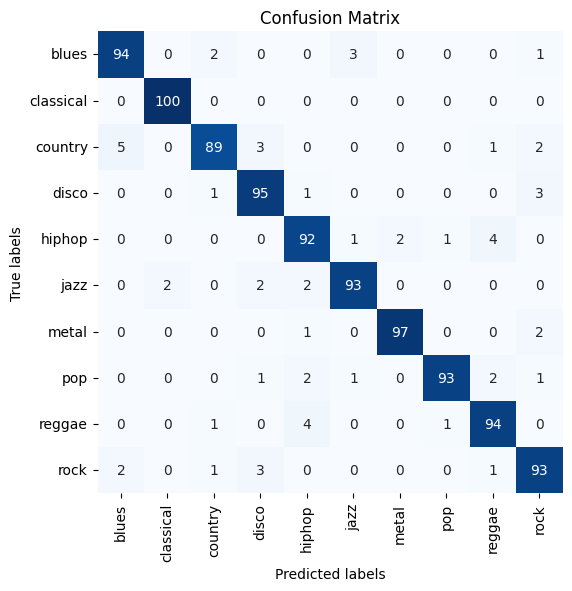

In [275]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=new_genre_labels.values(), yticklabels=new_genre_labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### PCA Analysis

In [276]:
!python -m pip install --upgrade scikit-learn seaborn networkx

In [277]:
import numpy as np

num_samples = X_train.shape[0]
sequence_length = X_train.shape[1]
spectrogram_height = X_train.shape[2]
spectrogram_width = X_train.shape[3]

# Reshape X_train to (total_images, height, width, channels)
X_train_reshaped = X_train.reshape(num_samples * sequence_length, spectrogram_height, spectrogram_width, 1)

# Extract cnn_model from best_model
cnn_model = best_model.layers[1].layer  # Accessing the cnn_model within the TimeDistributed layer

# Get outputs of cnn_model on X_train
cnn_outputs = cnn_model.predict(X_train_reshaped)



625/625 [==============================] - 36s 57ms/step


In [278]:
# Reshape cnn_outputs to match the original shape of X_train
cnn_outputs_reshaped = cnn_outputs.reshape(num_samples, sequence_length, -1)

# Average the CNN outputs for every 20 samples
averaged_cnn_outputs = np.mean(cnn_outputs_reshaped, axis=1)

In [279]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result_2d = pca.fit_transform(averaged_cnn_outputs)

print("Shape of PCA result:", pca_result_2d.shape)

Shape of PCA result: (999, 2)


In [280]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result_3d = pca.fit_transform(averaged_cnn_outputs)

print("Shape of PCA result:", pca_result_3d.shape)


Shape of PCA result: (999, 3)


In [281]:
genre_colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'cyan',
    4: 'magenta',
    5: 'yellow',
    6: 'black',
    7: 'brown',
    8: 'orange',
    9: 'purple'
}

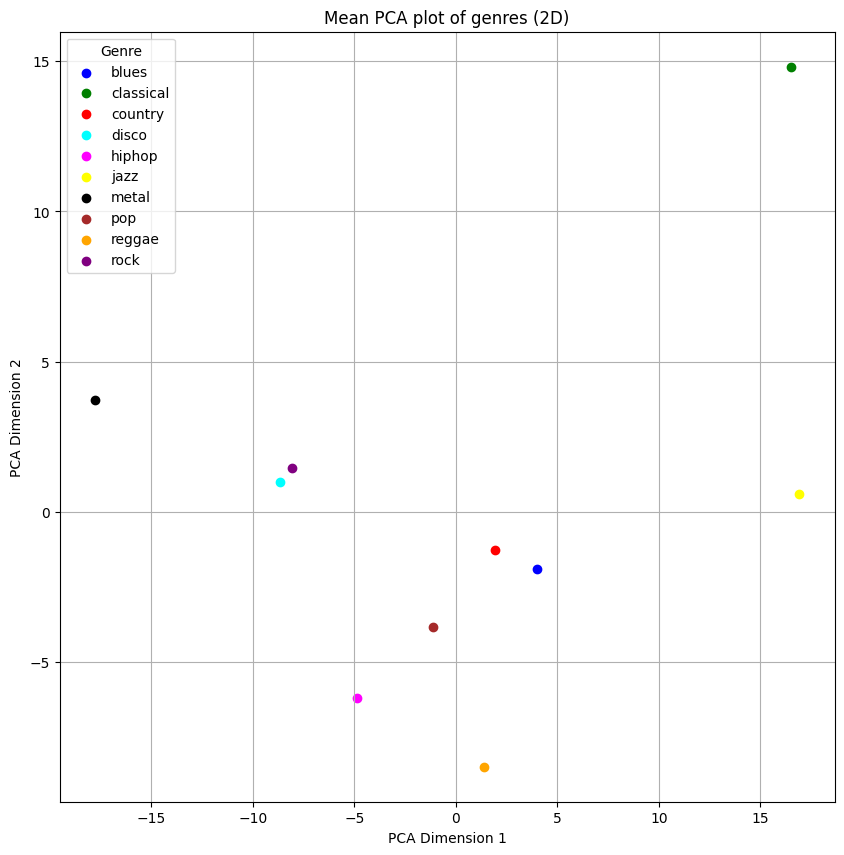

In [282]:
# Compute the mean of PCA-transformed coordinates for each genre
import matplotlib.pyplot as plt
genre_means_2d = np.zeros((len(new_genre_labels), 2))  # Initialize array to store means
for genre_label, color in new_genre_labels.items():
    genre_indices = np.where(y_train == genre_label)[0]
    genre_mean = np.mean(pca_result_2d[genre_indices], axis=0)
    genre_means_2d[genre_label] = genre_mean

# Create a scatter plot for mean coordinates with colors based on genre labels
plt.figure(figsize=(10, 10))
for genre_label, color in genre_colors.items():
    plt.scatter(genre_means_2d[genre_label, 0], genre_means_2d[genre_label, 1], color=color, label=f'{new_genre_labels[genre_label]}')

plt.title('Mean PCA plot of genres (2D)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Genre')
plt.grid(True)
plt.show()


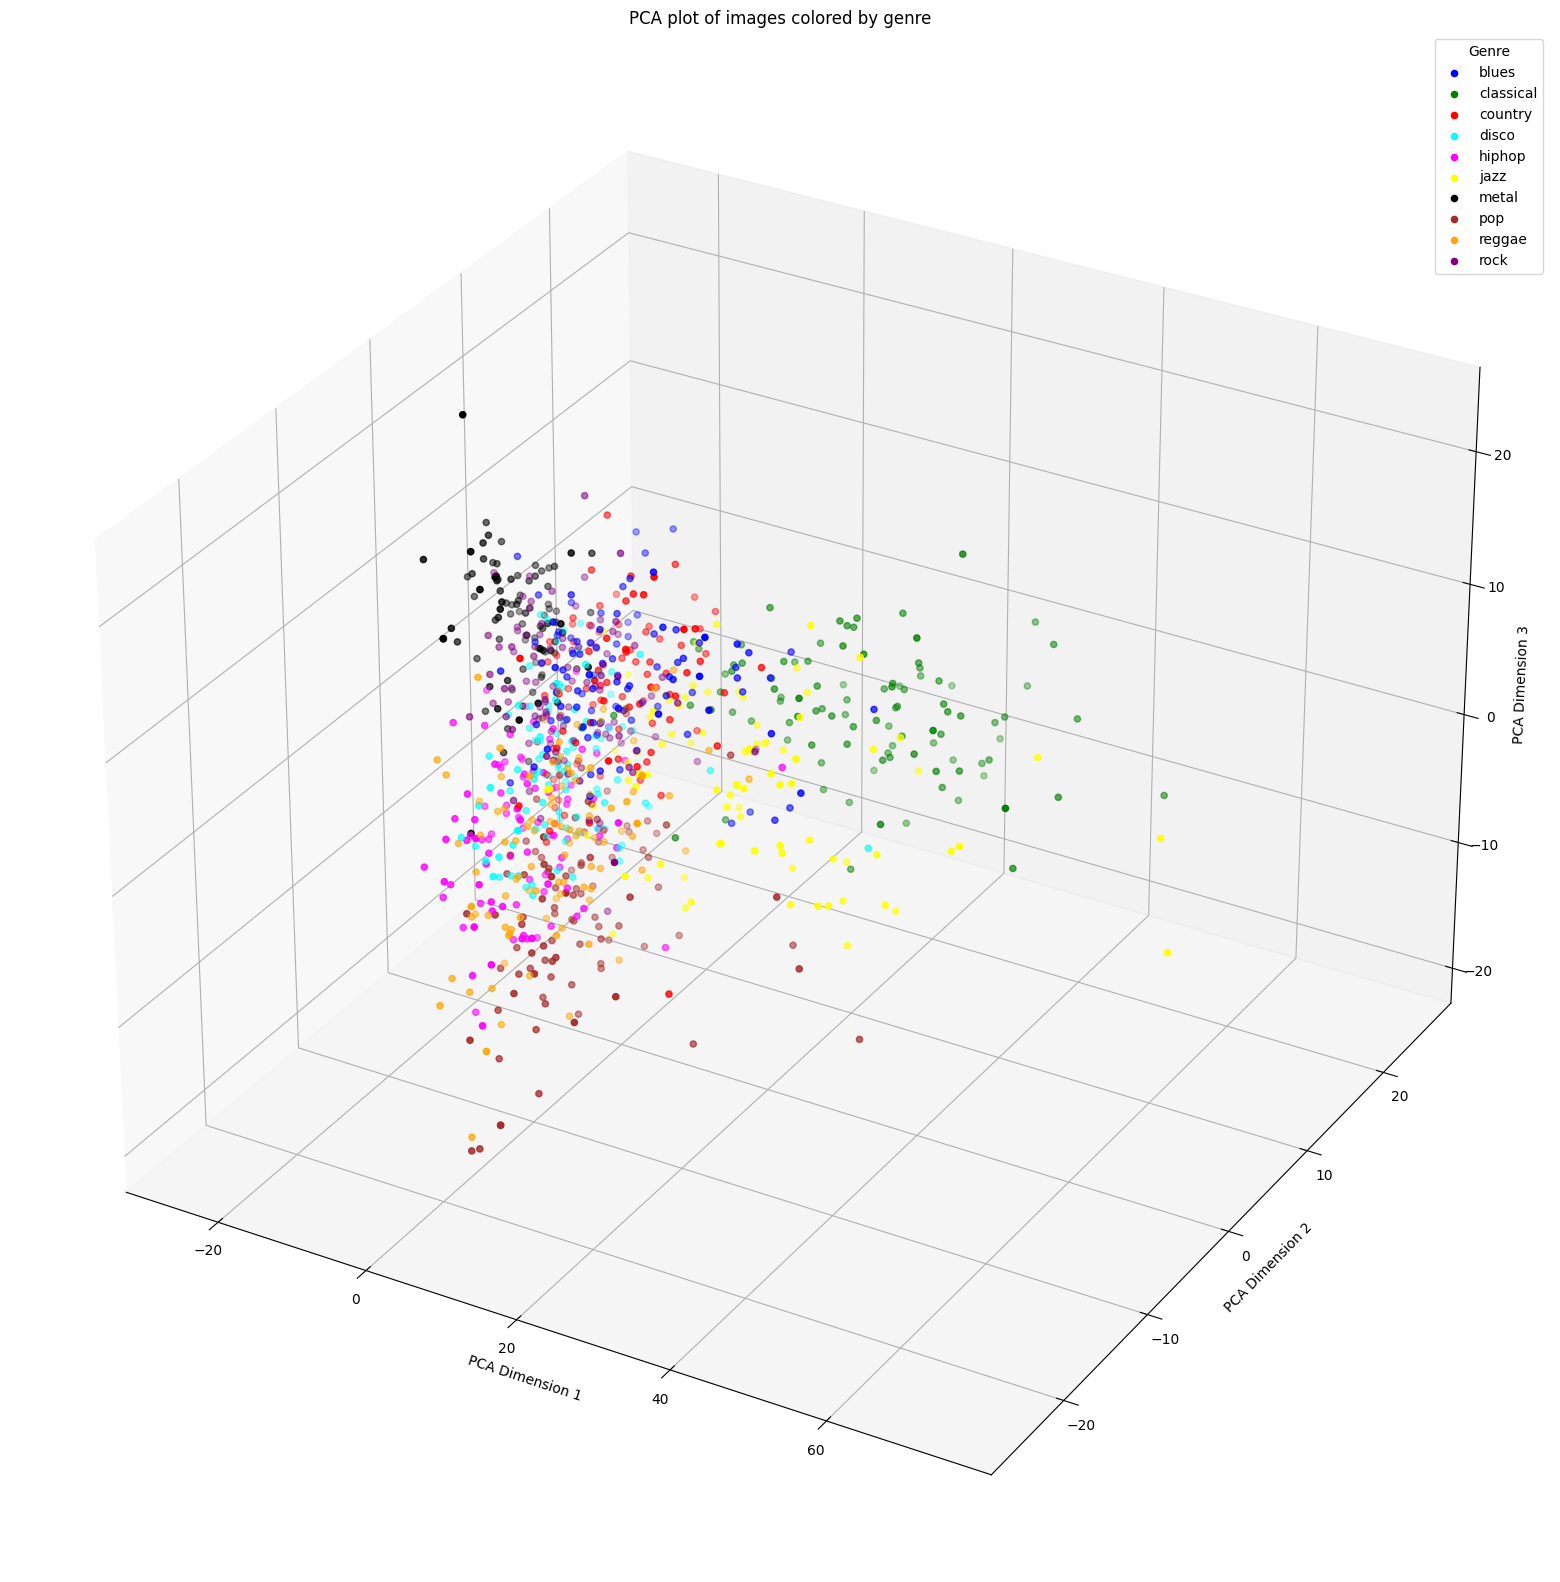

In [283]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 

# Create a 3D scatter plot for PCA-transformed coordinates with colors based on genre labels
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
for genre_label, color in genre_colors.items():
    genre_indices = np.where(y_train == genre_label)[0]
    ax.scatter(pca_result_3d[genre_indices, 0], pca_result_3d[genre_indices, 1], pca_result_3d[genre_indices, 2], color=color, label=f'{new_genre_labels[genre_label]}')

ax.set_title('PCA plot of images colored by genre')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.legend(title='Genre')
plt.show()

In [284]:
genre_means = np.zeros((len(new_genre_labels), 3))  # Initialize array to store means
for genre_label, color in new_genre_labels.items():
    genre_indices = np.where(y_train == genre_label)[0]
    genre_mean = np.mean(pca_result_3d[genre_indices], axis=0)
    genre_means[genre_label] = genre_mean

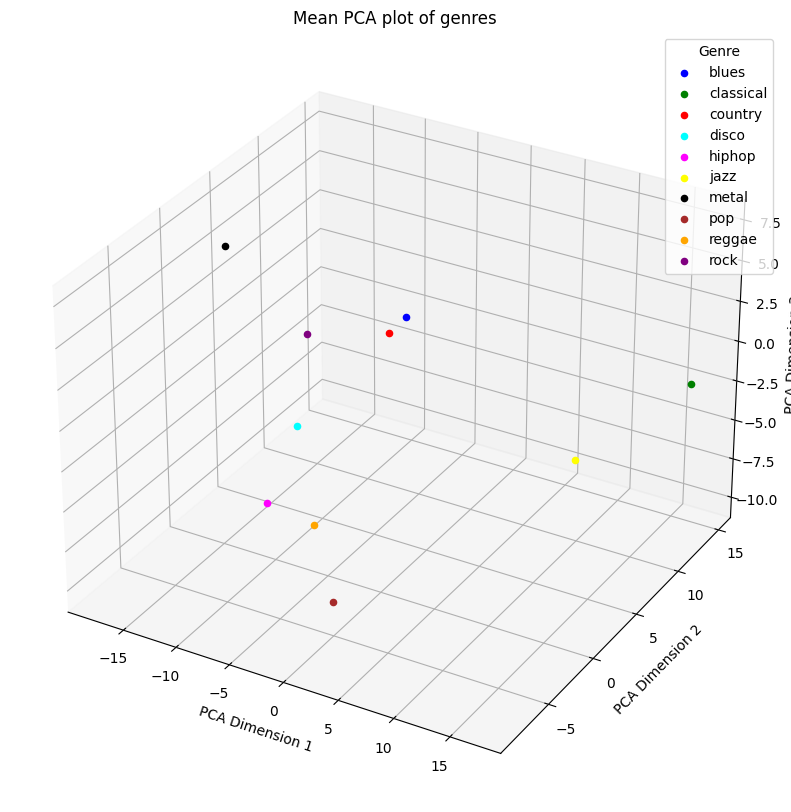

In [285]:

# Create a 3D scatter plot for mean coordinates with colors based on genre labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for genre_label, color in genre_colors.items():
    ax.scatter(genre_means[genre_label, 0], genre_means[genre_label, 1], genre_means[genre_label, 2], color=color, label=new_genre_labels[genre_label])

ax.set_title('Mean PCA plot of genres')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.legend(title='Genre')
plt.show()


In [301]:
threshold = 4.5

# Check combinations of genres
num_genres = len(genre_means)
found_combinations = []
checked_combinations = set()

for i in range(num_genres):
    for j in range(num_genres):
        for k in range(num_genres):
            if i != j != k:  # Ensure A, B, C are different genres
                A = genre_means[i]
                B = genre_means[j]
                C = genre_means[k]

                # Find D such that A - B + C = D
                D = A - B + C

                # Check if D vector is close to any other genre vector
                for m in range(num_genres):
                    if m != i != j != k:
                        if m not in (i, j, k):  # Ensure D is not one of A, B, C
                            if np.allclose(D, genre_means[m], atol=threshold):
                                # Sort and store the combination as a tuple to avoid duplicates
                                sorted_combination = tuple(sorted([i, j, k, m]))
                                if sorted_combination not in checked_combinations:
                                    checked_combinations.add(sorted_combination)
                                    found_combinations.append((i, j, k, m))

# Print the found combinations
print("Based on the PCA plot, the following equations were found:")
for i, combination in enumerate(found_combinations):
    genre_A, genre_B, genre_C, genre_D = combination
    print(f"{i + 1}. {new_genre_labels[genre_A]} - {new_genre_labels[genre_B]} + {new_genre_labels[genre_C]} = {new_genre_labels[genre_D]}")

Based on the PCA plot, the following equations were found:
1. blues - country + disco = rock
2. blues - country + hiphop = reggae
3. country - reggae + hiphop = rock
4. disco - metal + disco = pop
5. disco - metal + rock = pop
6. disco - pop + hiphop = rock
7. hiphop - metal + rock = reggae


In [287]:
# Find the two closest genres to a given genre
def find_closest_genres(genre_means, genre_label, num_closest=2):
    genre_mean = genre_means[genre_label]
    distances = np.linalg.norm(genre_means - genre_mean, axis=1)
    closest_genres = np.argsort(distances)[1:num_closest + 1]
    return closest_genres

In [288]:
# Find the closest two genres to each genre
closest_dict = {}
for genre_label, genre_name in new_genre_labels.items():
    closest_genres = find_closest_genres(genre_means, genre_label)
    closest_genre_names = [new_genre_labels[closest_genre] for closest_genre in closest_genres]
    closest_dict[genre_name] = [closest_genre_names[0], closest_genre_names[1]]
    print(f"The closest genres to {genre_name} are {closest_genre_names[0]} and {closest_genre_names[1]}")

The closest genres to blues are country and reggae
The closest genres to classical are jazz and blues
The closest genres to country are blues and reggae
The closest genres to disco are rock and hiphop
The closest genres to hiphop are reggae and pop
The closest genres to jazz are classical and blues
The closest genres to metal are rock and disco
The closest genres to pop are hiphop and reggae
The closest genres to reggae are hiphop and pop
The closest genres to rock are disco and hiphop


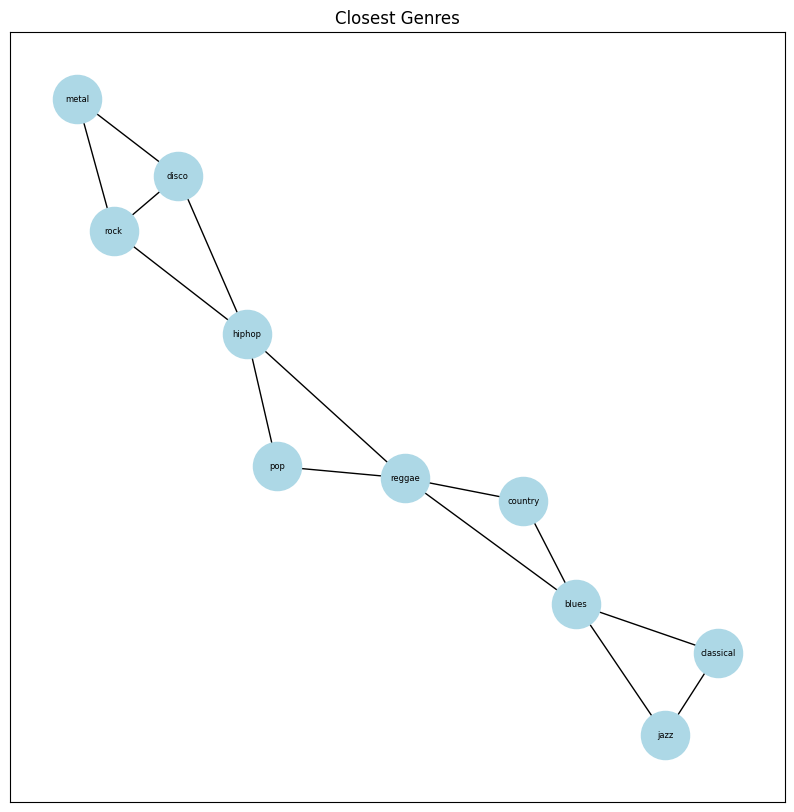

In [289]:
import networkx as nx
import matplotlib.pyplot as plt

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
closest_genres = [closest_dict[genre] for genre in genres]

G = nx.Graph()
G.add_nodes_from(genres)

for i, genre in enumerate(genres):
    closest = closest_genres[i]
    G.add_edges_from([(genre, closest[0]), (genre, closest[1])])
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='black', font_size=6, node_size=1200)

# Add a title
plt.title('Closest Genres')
plt.show()

### Attention Weights Analysis

In [290]:
classification_outputs, attention_scores = best_model_full.predict(X_train)
mean_attention_scores = np.mean(attention_scores, axis=1)
most_important_tokens = np.argmax(mean_attention_scores, axis=1)
total_importance = np.sum(mean_attention_scores, axis=1)

32/32 [==============================] - 35s 1s/step


In [291]:
# For each sample, max count of most important token is the sample most important token
from collections import Counter
most_important_tokens_per_sample = np.array([Counter(tokens).most_common(1)[0][0] for tokens in most_important_tokens])

In [292]:
for i, token_idx in enumerate(most_important_tokens):
        print(f"Sample {i}: Most important token is at index {token_idx}")
        if i > 0:
            break

Sample 0: Most important token is at index [11  9 11 11  9 11 15 15 11 11 11 11 15 15  7 11  8 16 16 15]
Sample 1: Most important token is at index [ 0 12 12 12 12 12 12 13 12 13 13 12 12  0 12 12 12 12 12 13]


In [293]:
# Add total_importance of samples of the same genre. Output shape should be (num_genres, sequence_length)
genre_importance = np.zeros((num_classes, sequence_length))
for genre_label in range(num_classes):
    genre_indices = np.where(y_train == genre_label)[0]
    genre_total_importance = np.sum(total_importance[genre_indices], axis=0)
    genre_importance[genre_label] = genre_total_importance

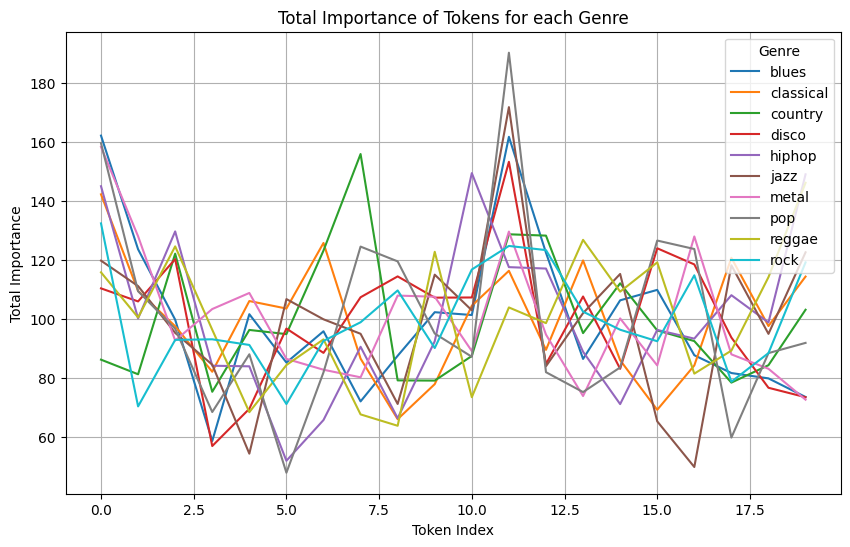

In [294]:
# Plot softmax of genre_importance for each genre
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for genre_label, genre_name in new_genre_labels.items():
    plt.plot(genre_importance[genre_label], label=genre_name)

plt.title('Total Importance of Tokens for each Genre')
plt.xlabel('Token Index')
plt.ylabel('Total Importance')
plt.legend(title='Genre')
plt.grid(True)
plt.show()

In [303]:
# Find the 5 most important tokens for each genre
most_important_tokens_per_genre = np.argsort(genre_importance, axis=1)[:, -4:]

# Print the 5 most important tokens for each genre
for genre_label, genre_name in new_genre_labels.items():
    print(f"{genre_name}: {most_important_tokens_per_genre[genre_label]}")


blues: [12  1 11  0]
classical: [13 17  6  0]
country: [ 6 12 11  7]
disco: [16  2 15 11]
hiphop: [ 2  0 19 10]
jazz: [17  0 19 11]
metal: [16  1 11  0]
pop: [ 7 15  0 11]
reggae: [ 9  2 13 19]
rock: [19 12 11  0]


In [305]:
# Find the overall most important tokens acrosss all genres
total_importance = np.sum(genre_importance, axis=0)
most_important_tokens_overall = np.argsort(total_importance)[-5:]
print("Overall most important tokens:", most_important_tokens_overall)

Overall most important tokens: [ 1 19  2  0 11]


In [9]:
classification_outputs, attention_scores = best_model_full.predict(X_train)
mean_attention_scores = np.mean(attention_scores, axis=1)
most_important_tokens = np.argmax(mean_attention_scores, axis=1)
total_importance = np.sum(mean_attention_scores, axis=1)

32/32 [==============================] - 27s 814ms/step


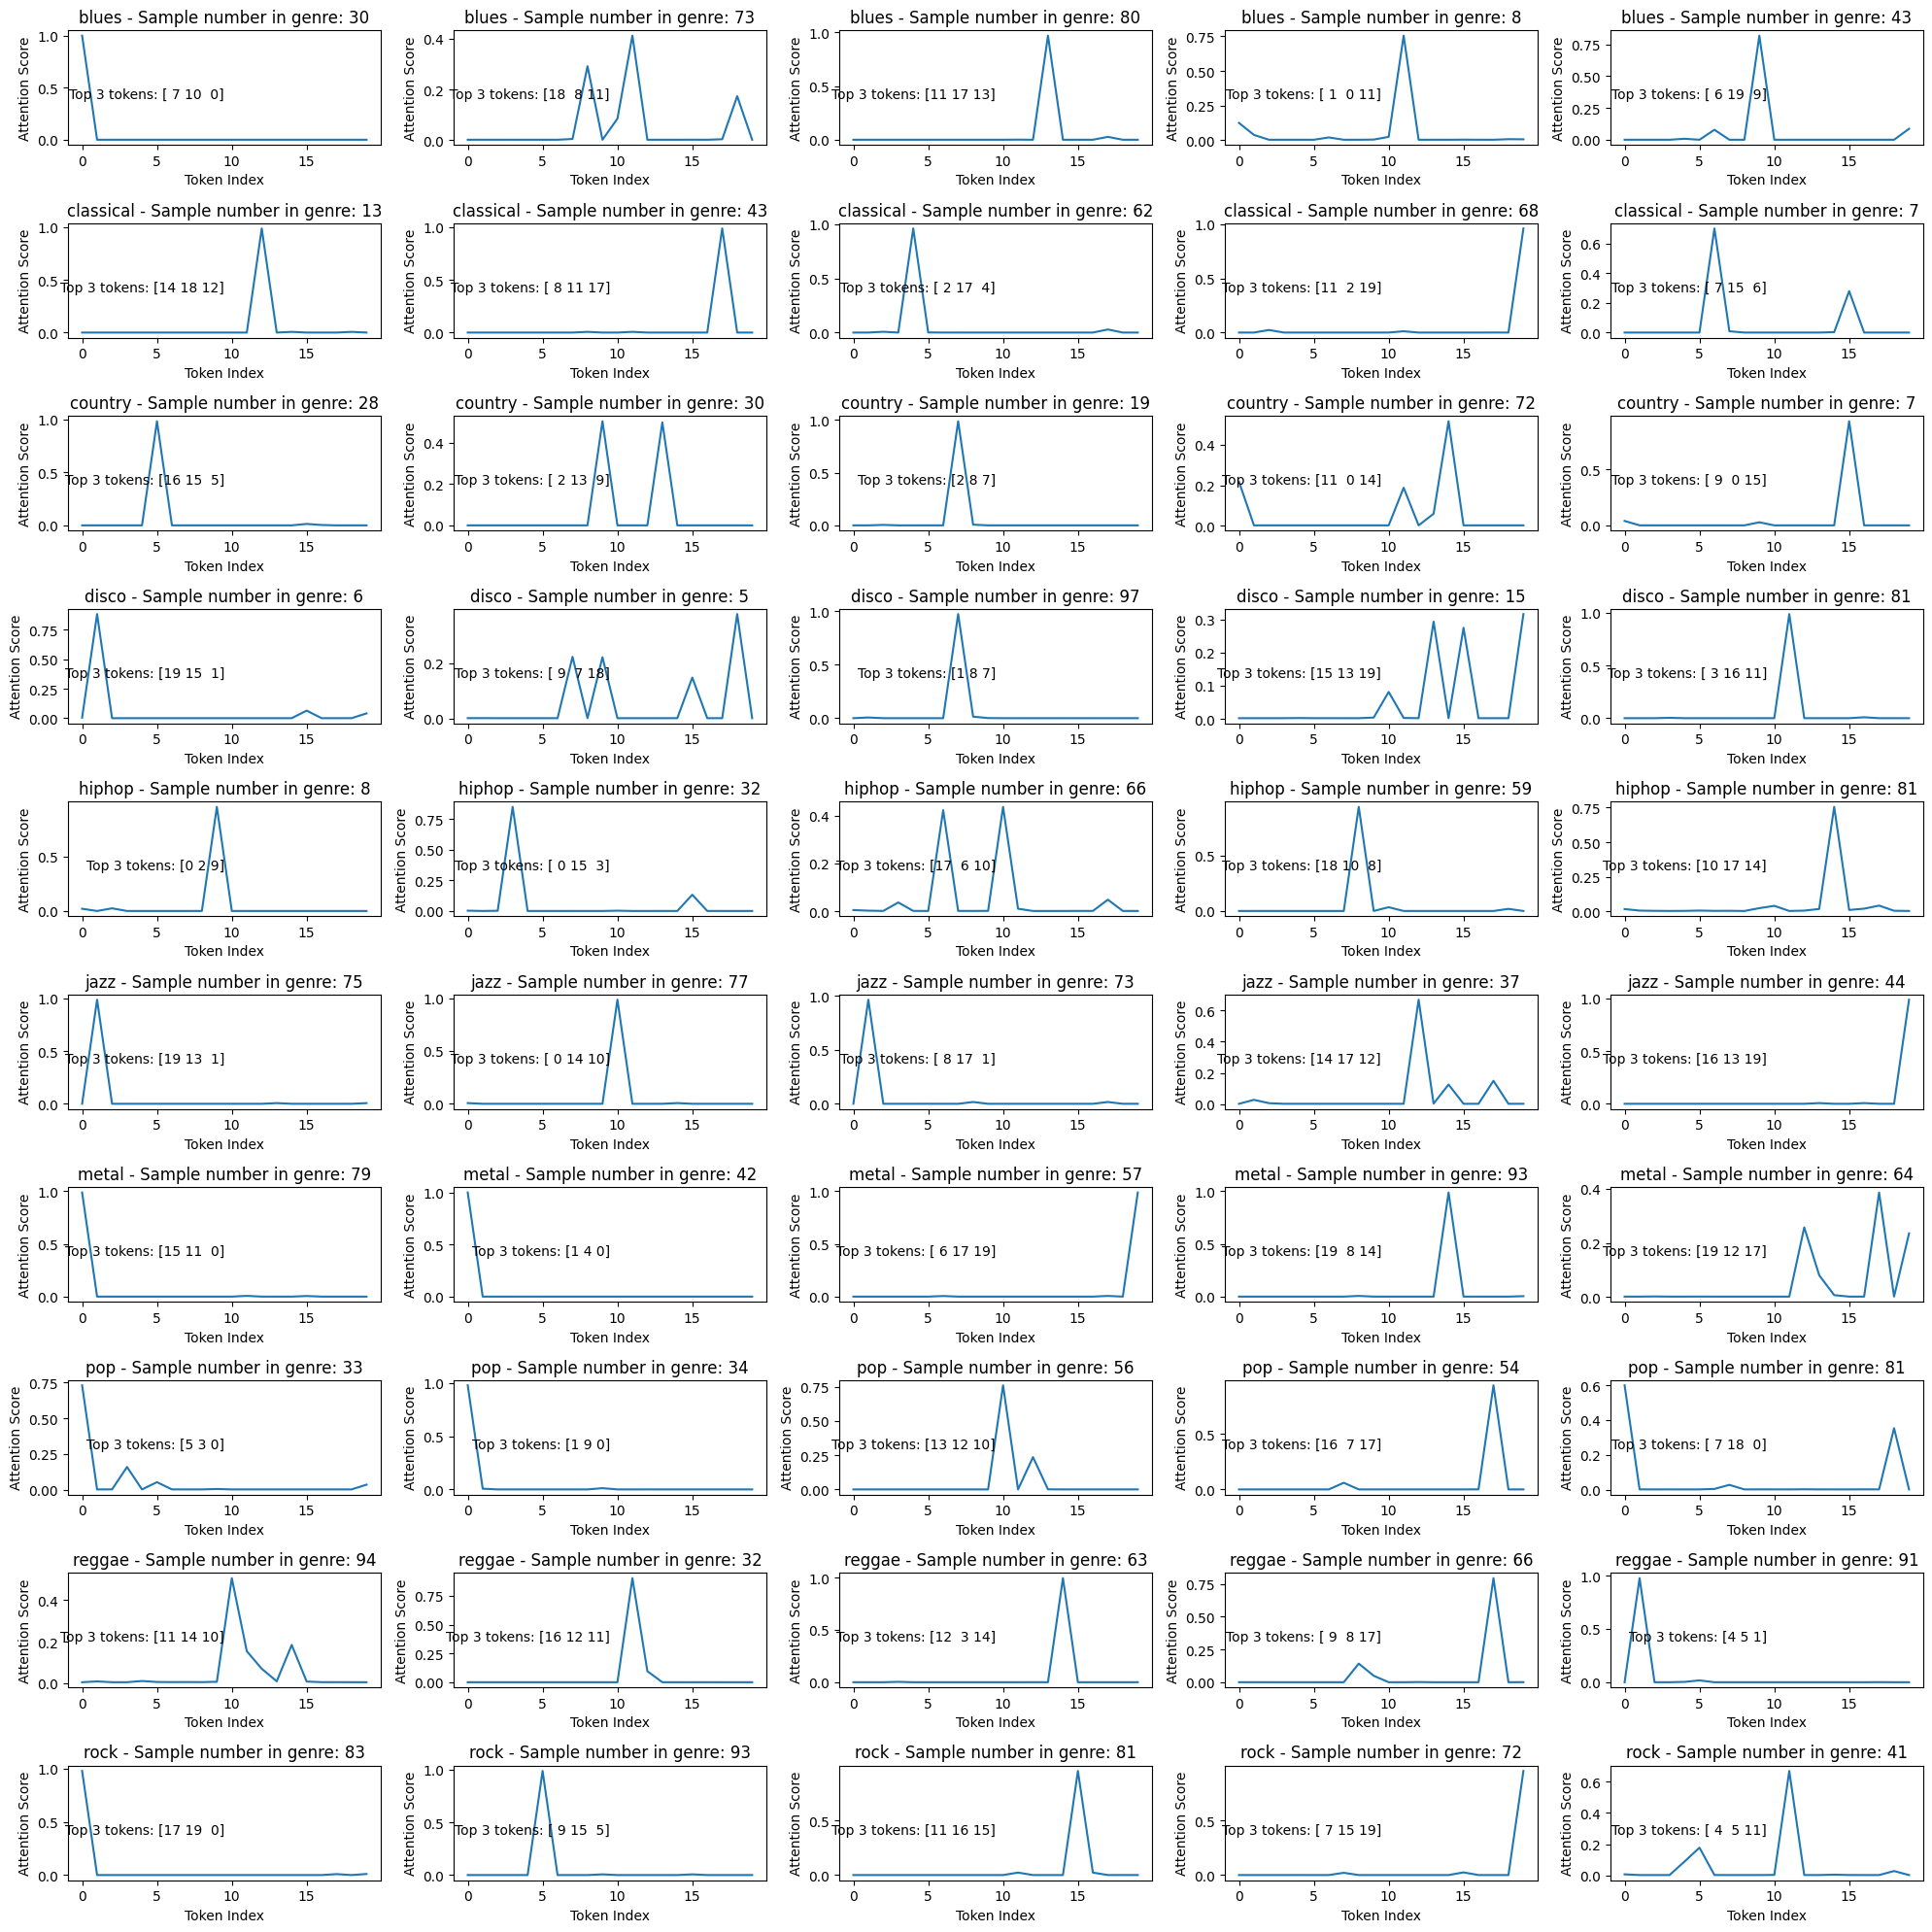

In [77]:
# Choose 3 random samples from each genre and plot the attention scores - use total_importance
import matplotlib.pyplot as plt
import seaborn as sns
import random

num_samples_per_genre = 5
plt.figure(figsize=(20, 20))
for genre_label, genre_name in new_genre_labels.items():
    genre_indices = np.where(y_train == genre_label)[0]
    random_sample_indices = random.sample(list(genre_indices), num_samples_per_genre)
    for i, sample_idx in enumerate(random_sample_indices):
        plt.subplot(num_classes, num_samples_per_genre, genre_label * num_samples_per_genre + i + 1)
        # plot softmax(total_importance) for each sample
        plt.plot([np.exp(score)/np.sum(np.exp(total_importance[sample_idx])) for score in total_importance[sample_idx]])  
        plt.title(f"{genre_name} - Sample number in genre: {sample_idx % 100}")
        plt.xlabel('Token Index')
        plt.ylabel('Attention Score')
        # Also print the three most important tokens for each sample inside the plot
        most_important_tokens = np.argsort(total_importance[sample_idx])[-3:]
        plt.text(0.5, 0.5, f"Top 3 tokens: {most_important_tokens}", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [80]:
# For each token, print the seconds it signifies - 0: 0-1.95s, 1: 1.5-3.45s, 2: 3-4.95s and so on
for i in range(20):
    print(f"Token {i}: {i * 4.48 * 0.3:.2f}s to {((i * 4.48 * 0.3) + 4.48):.2f}s")

Token 0: 0.00s to 4.48s
Token 1: 1.34s to 5.82s
Token 2: 2.69s to 7.17s
Token 3: 4.03s to 8.51s
Token 4: 5.38s to 9.86s
Token 5: 6.72s to 11.20s
Token 6: 8.06s to 12.54s
Token 7: 9.41s to 13.89s
Token 8: 10.75s to 15.23s
Token 9: 12.10s to 16.58s
Token 10: 13.44s to 17.92s
Token 11: 14.78s to 19.26s
Token 12: 16.13s to 20.61s
Token 13: 17.47s to 21.95s
Token 14: 18.82s to 23.30s
Token 15: 20.16s to 24.64s
Token 16: 21.50s to 25.98s
Token 17: 22.85s to 27.33s
Token 18: 24.19s to 28.67s
Token 19: 25.54s to 30.02s


Observations:
1. Blues - The important timesteps seem to be portions/ freuencies that are "abnormal, out of scale, and different from the rest". Also, wherever there are signficant "pauses" in the music - that seems to be characteristic of Blues. The guitars play a significant role, whenever the guitars play characteristic Blues licks, the model seems to catch on to it. 
2. Classical - Grandeur: When the cymbals come in, the strings and the horns - a magnum opus of the orchestra. That's what it picks up on. Sustenance of notes - when a note plays for a long time, it is very much used particularly in classical music to build up the next "act". Repetition - when the same "phrase" is repeated a few times over the piece, it is significant to the genre.
3. Country - Higher Frequencies (rarity). 

4. Disco - Build Ups. Also, alternate tokens are important, maybe due to the "up and down" nature of Disco genre. You see lots of peaks all adjacent to troughs then peak again in a repetitive fashion. Powerful vocals